<a href="https://colab.research.google.com/github/KaiWoessner/NFLDataAnalysis/blob/main/NFLMatchupCalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Install the library for NFL Data
!pip install nfl_data_py
!pip install pandas

In [31]:
# Imports
from math import pi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
from math import pi

# NFL Data Import
import nfl_data_py as nfl

from google.colab import drive

drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
stats = nfl.import_pbp_data([2023])

# Copy data
new_stats = stats.copy()

# Create Defensive EPA
new_stats['def_epa'] = -stats['epa']

stats = new_stats

# Filter Garbage Time
stats = stats[(stats["wp"] > .25) & (stats["wp"] < .975)]

2023 done.
Downcasting floats.


In [33]:
#REDZONE
redzone = stats[stats["drive_inside20"] == 1.0]
redzone_td = redzone[redzone["touchdown"] == 1.0]

redzone_drives = redzone.groupby("posteam")["drive_real_start_time"].nunique().reset_index()
redzone_tds = redzone_td.groupby("posteam")["touchdown"].size().reset_index()

redzone_tds["redzone_eff"] = redzone_tds["touchdown"] / redzone_drives["drive_real_start_time"] * 100

redzone_tds["redzone_eff_rank"] = redzone_tds["redzone_eff"].rank(method="max", ascending=True).astype(int)
redzone_tds = redzone_tds.sort_values("redzone_eff_rank", ascending=False).reset_index(drop = True)

redzone_tds = redzone_tds.rename(columns={"posteam": "team"})

In [34]:
passing = stats[stats["play_type"] == "pass"]
rushing = stats[stats["play_type"] == "run"]

# OFFENSE
passing_total = passing.groupby("posteam").size().reset_index(name = "pass_plays")
off_passing = passing.groupby("posteam")["epa"].sum().reset_index()

off_passing["off_passing_epa"] = off_passing["epa"] / passing_total["pass_plays"]

rushing_total = rushing.groupby("posteam").size().reset_index(name = "run_plays")
off_rushing = rushing.groupby("posteam")["epa"].sum().reset_index()

off_rushing["off_rush_epa"] = off_rushing["epa"] / rushing_total["run_plays"]


off_passing["off_passing_rank"] = off_passing["off_passing_epa"].rank(method="max", ascending=True).astype(int)
off_passing = off_passing.sort_values("off_passing_rank", ascending=False).reset_index(drop = True)

off_rushing["off_rushing_rank"] = off_rushing["off_rush_epa"].rank(method="max", ascending=True).astype(int)
off_rushing = off_rushing.sort_values("off_rushing_rank", ascending=False).reset_index(drop = True)

off_passing = off_passing.rename(columns={"posteam": "team"})
off_rushing = off_rushing.rename(columns={"posteam": "team"})

In [35]:
# DEFENSE
passing_total = passing.groupby("defteam").size().reset_index(name = "pass_plays")
def_passing = passing.groupby("defteam")["def_epa"].sum().reset_index()

def_passing["def_passing_epa"] = def_passing["def_epa"] / passing_total["pass_plays"]

rushing_total = rushing.groupby("defteam").size().reset_index(name = "run_plays")
def_rushing = rushing.groupby("defteam")["def_epa"].sum().reset_index()

def_rushing["def_rush_epa"] = def_rushing["def_epa"] / rushing_total["run_plays"]

def_passing["def_passing_rank"] = def_passing["def_passing_epa"].rank(method="max", ascending=True).astype(int)
def_passing = def_passing.sort_values("def_passing_rank", ascending=False).reset_index(drop = True)

def_rushing["def_rushing_rank"] = def_rushing["def_rush_epa"].rank(method="max", ascending=True).astype(int)
def_rushing = def_rushing.sort_values("def_rushing_rank", ascending=False).reset_index(drop = True)

def_passing = def_passing.rename(columns={"defteam": "team"})
def_rushing = def_rushing.rename(columns={"defteam": "team"})

In [36]:
# SUCCESS (Not Used)
passing = stats[stats["play_type"] == "pass"]
rushing = stats[stats["play_type"] == "run"]

passing_total = passing.groupby("posteam").size().reset_index(name = "pass_plays")
pass_success = passing.groupby("posteam")["success"].sum().reset_index()

pass_success["pass_success_percent"] = pass_success["success"] / passing_total["pass_plays"] * 100

rushing_total = rushing.groupby("posteam").size().reset_index(name = "run_plays")
rushing_success = rushing.groupby("posteam")["success"].sum().reset_index()

rushing_success["rush_success_percent"] = rushing_success["success"] / rushing_total["run_plays"] * 100

pass_success["pass_success_rank"] = pass_success["pass_success_percent"].rank(method="max", ascending=True).astype(int)
pass_success = pass_success.sort_values("pass_success_rank", ascending=False).reset_index(drop = True)

rushing_success["rush_success_rank"] = rushing_success["rush_success_percent"].rank(method="max", ascending=True).astype(int)
rushing_success = rushing_success.sort_values("rush_success_rank", ascending=False).reset_index(drop = True)

pass_success = pass_success.rename(columns={"posteam": "team"})
rushing_success = rushing_success.rename(columns={"posteam": "team"})

In [40]:
#TURNOVERS (Not used)
off_fumble = stats.groupby("posteam")["fumble_lost"].sum().reset_index()
off_int = stats.groupby("posteam")["interception"].sum().reset_index()

def_fumble = stats.groupby("defteam")["fumble_lost"].sum().reset_index()
def_int = stats.groupby("defteam")["interception"].sum().reset_index()

turnovers = pd.DataFrame(off_fumble["posteam"])
turnovers["turnover_diff"] = (def_fumble["fumble_lost"] + def_int["interception"]) - (off_fumble["fumble_lost"] + off_int["interception"])

turnovers["turnover_rank"] = turnovers["turnover_diff"].rank(method="max", ascending=True).astype(int)
turnovers = turnovers.sort_values("turnover_rank", ascending=False).reset_index(drop = True)

turnovers = turnovers.rename(columns={"posteam": "team"})

In [38]:
# Merge rank dataframes
column1 = off_passing
data_frames = [off_rushing, def_passing, def_rushing, turnovers, redzone_tds]

for columns in data_frames:
    column1 = pd.merge(column1, columns, on='team', how='left')

fin_ranks = column1[["team", "off_passing_rank","off_rushing_rank", "def_passing_rank", "def_rushing_rank", "redzone_eff_rank"]]

First Team Abbreviation: LAC
Second Team Abbreviation: CHI


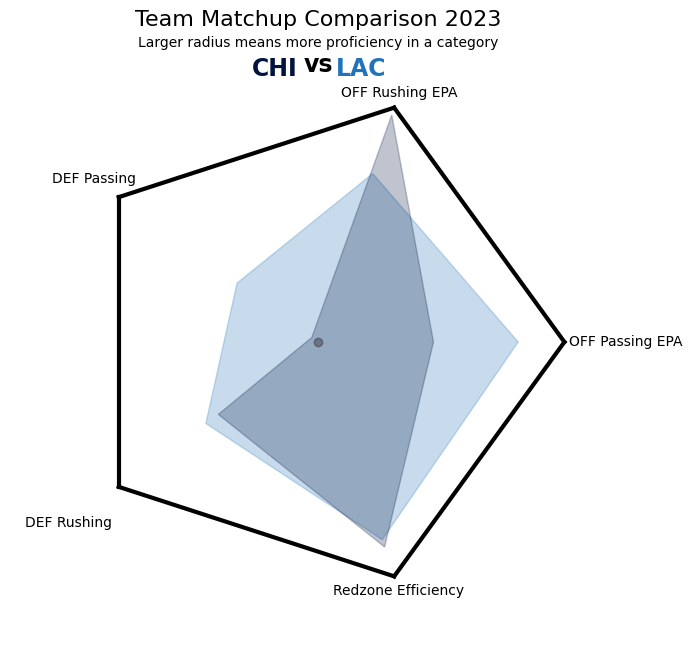

In [39]:
def matchup(inp1, inp2):
  matchup = fin_ranks[fin_ranks["team"].isin([inp1, inp2])]

  teamcolor = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
            'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
            'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
            'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
            'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
            'TEN':'#4095D1','WAS':'#FFC20F'}

  tm_colors = [teamcolor.get(team) for team in matchup["team"]]

  categories = ["off_passing_rank", "off_rushing_rank", "def_passing_rank", "def_rushing_rank", "redzone_eff_rank"]
  data = matchup.loc[:, categories].values

  first_column = data[:, 0]

  # Append the first column to the end
  data = np.hstack((data, first_column.reshape(-1, 1)))

  category_count = len(list(matchup.columns[1:]))

  labels = ['OFF Passing EPA', 'OFF Rushing EPA', 'DEF Passing', 'DEF Rushing', "Redzone Efficiency"]

  # Create a list of angles for each category
  angles = [n / float(category_count) * 2 * np.pi for n in range(category_count)]
  angles += angles[:1]


  # Make the plot
  fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))


  # Plot the data
  for i in range(len(data)):
    ax.fill(angles, data[i], color=tm_colors[i], alpha=0.25)

  # Add a main title
  ax.set_title('Team Matchup Comparison 2023', fontsize=16)

  # Add a subtitle
  subtitle = 'Larger radius means more proficiency in a category'
  plt.text(0.5, 0.98, subtitle, fontsize=10, ha='center', transform=ax.transAxes)

  # Add labels
  ax.text(angles[0], 40, labels[0], ha='center', va='center')
  ax.text(angles[1], 34, labels[1], ha='center', va='center')
  ax.text(angles[2], 36, labels[2], ha='center', va='center')
  ax.text(angles[3], 40, labels[3], ha='center', va='center')
  ax.text(angles[4], 34, labels[4], ha='center', va='center')

  # Matchup
  color1 = teamcolor.get(inp1)
  color2 = teamcolor.get(inp2)

  x = np.pi / 2
  y = 36

  ax.text(x - np.pi/20, y, inp1, ha='center', va='center', fontsize=17, weight='bold', color=color1)
  ax.text(x + np.pi/20, y, inp2, ha='center', va='center', fontsize=17, weight='bold', color=color2)
  ax.text(x, y, "vs", ha='center', va='center', fontsize=17, weight='bold', color="k")



  plt.scatter(0, 0, c='k', alpha = 0.3, marker='o')

  pen_coords = [
      (0, 32),
      (2 * np.pi / 5, 32),
      ( 4*np.pi / 5, 32),
      (6 * np.pi / 5 , 32),
      (8 * np.pi / 5, 32)
  ]

  # Add lines connecting the vertices of the hex
  for i in range(len(pen_coords) - 1):
      x1, y1 = pen_coords[i]
      x2, y2 = pen_coords[i + 1]
      ax.plot([x1, x2], [y1, y2], color='k', linewidth=3)

  # Connect the last point to the first point
  x1, y1 = pen_coords[-1]
  x2, y2 = pen_coords[0]
  ax.plot([x1, x2], [y1, y2], color='k', linewidth=3)

  ax.yaxis.grid(True, linestyle='-', alpha=0.0, color='none')
  ax.xaxis.grid(True, linestyle='-', alpha=0.0, color='none')

  ax.spines['polar'].set_visible(False)

  plt.ylim(0, 40)
  ax.set_yticks(np.arange(0, 40, 2))

  ax.set_yticklabels([])
  ax.set_xticklabels([])

  # Show the plot
  plt.show()

inp1 = input("First Team Abbreviation: ")
inp2 = input("Second Team Abbreviation: ")

matchup(inp1, inp2)